### **Explicacion breve:**

Modelo de clasificación para predecir la dirección del precio del día siguiente (adj_close).

Usaremos:

Tarea: Clasificación binaria (Precio Sube = 1, Precio Baja o Igual = 0).

Características: Precio de cierre del día anterior, volumen del día anterior, y dos indicadores técnicos simples (SMA de 10 días, RSI de 14 días). Nota: Una ingeniería de características más exhaustiva (más lags, más indicadores) suele mejorar los resultados.

Modelos: Regresión Logística (como baseline) y Random Forest Classifier (más potente).

Evaluación: Accuracy, Precision, Recall, F1-Score, ROC AUC y Matriz de Confusión.

Estructura: Se integra dentro del bucle existente para los 5 primeros ETFs.

Pre-requisito: Necesitarás instalar una biblioteca para calcular indicadores técnicos fácilmente. pandas-ta es una buena opción:

In [ ]:
!pip uninstall pandas-ta numpy -y
print("--- Desinstalación Completa ---")

Found existing installation: numpy 2.2.4
Uninstalling numpy-2.2.4:
  Successfully uninstalled numpy-2.2.4
--- Desinstalación Completa ---


In [ ]:
!pip install numpy~=1.26.0
print("--- NumPy 1.x Instalado ---")

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
--- NumPy 1.x Instalado ---


In [ ]:
# Verificar versiones después de reiniciar
!pip show pandas-ta numpy pandas

print("\n--- Intentando importar ---")
try:
    import pandas_ta as ta
    import pandas as pd
    import numpy as np
    print(f"Importación exitosa!")
    print(f"Pandas-TA version: {ta.version()}")
    print(f"NumPy version: {np.__version__}")
    print(f"Pandas version: {pd.__version__}")
except ImportError as e:
    print(f"ERROR al importar después de ajustar versiones: {e}")

Name: numpy
Version: 1.26.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2023, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYR

In [ ]:
!pip install --force-reinstall pandas

  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalli

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv('top20_ETFs.csv')
df_top20 = df.copy()

In [ ]:
import pandas as pd
import numpy as np
# --- Modelos y Herramientas ---
from sklearn.model_selection import train_test_split, TimeSeriesSplit # Usaremos train_test_split para dividir la porción de interpolación
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import pandas_ta as ta # Para indicadores técnicos
# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns
# --- Otros ---
import warnings
from datetime import timedelta

# Ignorar algunas advertencias comunes
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


# --- 0. Carga y Preparación Inicial ---
# Asegúrate de que df_top20 esté cargado
# Ejemplo:
# df_top20 = pd.read_csv('tu_archivo_etfs.csv')

TOP_N_ETFS = 5 # Procesar solo los 5 primeros ETFs

required_cols = ['fund_symbol', 'price_date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'Clasificacion']
missing_cols = [col for col in required_cols if col not in df_top20.columns]
if missing_cols:
    raise ValueError(f"Faltan las siguientes columnas requeridas: {missing_cols}")

# --- 1. Preparar Datos y Seleccionar Top N ETFs por 'Clasificacion' ---
df_processed = df_top20.copy()
try:
    df_processed['price_date'] = pd.to_datetime(df_processed['price_date'])
except Exception as e:
    print(f"Error al convertir 'price_date': {e}")
    exit()

df_processed['Clasificacion'] = pd.to_numeric(df_processed['Clasificacion'], errors='coerce')
df_sorted_by_class = df_processed.sort_values(by=['Clasificacion', 'price_date'], ascending=[True, True], na_position='last')
ordered_symbols = df_sorted_by_class['fund_symbol'].unique()
top_N_etfs_list = [symbol for symbol in ordered_symbols if pd.notna(symbol)][:TOP_N_ETFS]

if len(top_N_etfs_list) < TOP_N_ETFS:
    print(f"Advertencia: Solo se encontraron {len(top_N_etfs_list)} ETFs únicos.")
else:
    print(f"Se seleccionaron los siguientes {len(top_N_etfs_list)} ETFs:")
print(top_N_etfs_list)
print("-" * 50)

# Ordenar el DF original para el bucle
df_top20 = df_top20.sort_values(by=['fund_symbol', 'price_date']).reset_index(drop=True)


# --- 2. Bucle para Procesar Cada ETF ---
classification_results = {}

for etf_symbol in top_N_etfs_list:
    print(f"\n--- Procesando Clasificación para ETF: {etf_symbol} ---")
    classification_results[etf_symbol] = {}

    # Filtrar datos
    df_etf = df_top20[df_top20['fund_symbol'] == etf_symbol].copy()
    df_etf = df_etf.sort_values(by='price_date').reset_index(drop=True)

    # Verificar datos suficientes ANTES de ingeniería de features
    min_data_points = 50 # Necesitamos más datos para lags e indicadores
    if len(df_etf) < min_data_points:
        print(f"Datos insuficientes para {etf_symbol} (encontrados {len(df_etf)}, mínimo {min_data_points}). Saltando clasificación...")
        continue

    # --- 3. Ingeniería de Características para Clasificación ---

    # 3.1 Crear Variable Objetivo (Target): Dirección del día siguiente
    # Calcular diferencia de precio con el día SIGUIENTE
    df_etf['Price_Diff'] = df_etf['adj_close'].diff().shift(-1)
    # Crear target: 1 si el precio subió, 0 si bajó o se mantuvo igual
    df_etf['Target_Direction'] = np.where(df_etf['Price_Diff'] > 0, 1, 0)

    # 3.2 Crear Características (Features)
    # Lags (datos del día anterior)
    df_etf['close_lag1'] = df_etf['adj_close'].shift(1)
    df_etf['volume_lag1'] = df_etf['volume'].shift(1)

    # Indicadores Técnicos (usando pandas_ta)
    try:
        df_etf.ta.sma(length=10, append=True) # Añade columna 'SMA_10'
        df_etf.ta.rsi(length=14, append=True) # Añade columna 'RSI_14'
        features_calculated = True
    except Exception as e:
        print(f"  Error calculando indicadores técnicos para {etf_symbol}: {e}")
        features_calculated = False
        continue # Saltar este ETF si fallan los indicadores

    # Lista final de features a usar
    features = ['close_lag1', 'volume_lag1', 'SMA_10', 'RSI_14']
    target = 'Target_Direction'

    # 3.3 Limpiar NaNs generados por lags, indicadores y el shift del target
    df_etf_clean = df_etf.dropna(subset=features + [target]).copy()

    # Verificar datos suficientes DESPUÉS de limpiar NaNs
    if len(df_etf_clean) < 30: # Necesitamos suficientes para train/test split
        print(f"Datos insuficientes para {etf_symbol} después de limpiar NaNs ({len(df_etf_clean)}). Saltando clasificación...")
        continue

    # --- 4. Preparar Datos para Modelo ---
    X = df_etf_clean[features]
    y = df_etf_clean[target]
    dates_clean = df_etf_clean['price_date']

    # --- 5. División Interpolación (80%) / Extrapolación (20%) ---
    # Usaremos la parte de interpolación para entrenar y probar el clasificador
    # La "extrapolación" aquí significa probar en el 20% más reciente del historial *limpio*
    n_total_clean = len(df_etf_clean)
    n_interp_clean = int(n_total_clean * 0.80)
    #n_extrap_clean = n_total_clean - n_interp_clean # No usado directamente para entrenar/testear aquí

    X_interp = X.iloc[:n_interp_clean]
    y_interp = y.iloc[:n_interp_clean]
    # X_extrap = X.iloc[n_interp_clean:] # Podríamos usarlo para una evaluación final "fuera de muestra"
    # y_extrap = y.iloc[n_interp_clean:]

    # --- 6. Dividir Interpolación en Entrenamiento (80%) y Prueba (20%) ---
    # ¡Importante usar shuffle=False para mantener el orden temporal!
    if len(X_interp) < 10: # Asegurar mínimo para split
         print(f"Conjunto de interpolación muy pequeño para dividir en train/test ({len(X_interp)}). Saltando.")
         continue

    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
        X_interp, y_interp, dates_clean.iloc[:n_interp_clean], # Pasar fechas correspondientes
        test_size=0.20,
        shuffle=False # CRUCIAL para series temporales
    )

    print(f"Tamaño datos limpios: {n_total_clean}")
    print(f"División para clasificación -> Train: {len(X_train)}, Test: {len(X_test)}")

    # --- 7. Escalado de Características ---
    # Es buena práctica escalar, especialmente para Regresión Logística
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- 8. Entrenamiento y Evaluación de Modelos ---
    models_to_test = {
        "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'), # Balanced para clases desiguales
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    }

    for model_name, model in models_to_test.items():
        print(f"\n--- {model_name} ---")

        # Entrenar
        try:
            model.fit(X_train_scaled, y_train)
        except Exception as e:
            print(f"  Error entrenando {model_name}: {e}")
            continue

        # Predecir en el conjunto de prueba
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1] # Probabilidad de la clase positiva (1)

        # Evaluar
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        try:
            roc_auc = roc_auc_score(y_test, y_proba)
        except ValueError: # Puede pasar si solo hay una clase en y_test
             roc_auc = float('nan')

        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")
        # print("\n  Classification Report:")
        # print(classification_report(y_test, y_pred, zero_division=0)) # Reporte detallado

        # Guardar resultados (opcional)
        classification_results[etf_symbol][model_name] = {
            'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc
        }

        # Visualizar Matriz de Confusión
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Pred Baja/Igual', 'Pred Sube'],
                    yticklabels=['Real Baja/Igual', 'Real Sube'])
        plt.title(f'Matriz de Confusión - {model_name}\nETF: {etf_symbol}')
        plt.ylabel('Valor Real')
        plt.xlabel('Predicción')
        plt.show()

    print("-" * 30)

print("\nAnálisis de Clasificación Completado.")

ModuleNotFoundError: No module named 'pandas_ta'

### **Explicación de los Pasos Clave:**

Importaciones: Se añaden las clases y funciones necesarias para clasificación y pandas-ta.

Bucle Principal: Se mantiene la estructura iterando por los ETFs.

Ingeniería de Características (Paso 3):

Target: Se calcula Price_Diff usando .diff().shift(-1) para obtener la diferencia entre el día actual y el siguiente. Luego, np.where crea la columna binaria Target_Direction.

Features: Se crean lags (.shift(1)) de adj_close y volume. Se usa df_etf.ta.sma() y df_etf.ta.rsi() para añadir indicadores SMA y RSI directamente al DataFrame.

Limpieza de NaNs: Es crucial llamar a dropna() después de crear todas las features y el target, ya que estas operaciones introducen NaNs al principio de la serie.

Preparación y División (Pasos 4, 5, 6):

Se separan X e y del DataFrame limpio.

Se divide el DataFrame limpio en 80% (interpolación) y 20% (extrapolación, aunque no se usa directamente aquí para entrenar/testear, sino para separar el período de prueba).

Se usa train_test_split sobre la porción de interpolación (X_interp, y_interp) con shuffle=False para crear los conjuntos de entrenamiento y prueba, manteniendo el orden temporal (el test set es el 20% más reciente de la porción de interpolación).

Escalado (Paso 7): Se usa StandardScaler ajustado (fit) solo en X_train y luego se aplica (transform) a X_train y X_test.

Entrenamiento y Evaluación (Paso 8):

Se definen los modelos (Logistic Regression, Random Forest). Se usa class_weight='balanced' como una forma simple de manejar el posible desequilibrio si un día sube mucho más a menudo que baja, o viceversa.

Se itera sobre los modelos.

Se entrena (.fit) cada modelo con los datos de entrenamiento escalados.

Se predice (.predict) las clases y (.predict_proba) las probabilidades en el conjunto de prueba escalado.

Se calculan las métricas de clasificación (accuracy, precision, recall, f1, roc_auc). zero_division=0 en precision_score y recall_score evita errores si una clase no es predicha.

Se genera y muestra la Matriz de Confusión usando seaborn.heatmap para una visualización clara de los Verdaderos Positivos, Falsos Positivos, Verdaderos Negativos y Falsos Negativos.

Este ejemplo te da una base sólida. Puedes expandirlo añadiendo más características, probando otros modelos de clasificación, y realizando una búsqueda de hiperparámetros (GridSearchCV con TimeSeriesSplit) para optimizar el rendimiento.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv('top20_ETFs.csv')
df_top20 = df.copy()

Se seleccionaron los siguientes 5 ETFs:
['TECL', 'TQQQ', 'SOXL', 'RETL', 'UPRO']
--------------------------------------------------

--- Procesando Clasificación para ETF: TECL ---
  Calculando características manuales para TECL...
  Características usadas: ['close_lag1', 'volume_lag1', 'SMA_10', 'ROC_14']
  Tamaño después de limpiar NaNs: 3239
  División para clasificación -> Train: 2072, Test: 519

  --- Evaluando: Logistic Regression ---
    Accuracy: 0.5723
    Precision: 0.5723
    Recall: 1.0000
    F1-Score: 0.7279
    ROC AUC: 0.4501


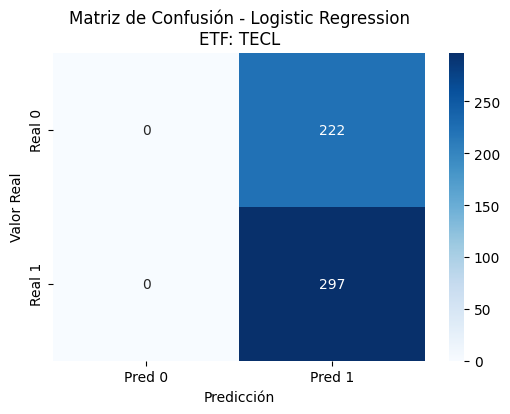


  --- Evaluando: Random Forest ---
    Accuracy: 0.4297
    Precision: 0.5714
    Recall: 0.0135
    F1-Score: 0.0263
    ROC AUC: 0.4956


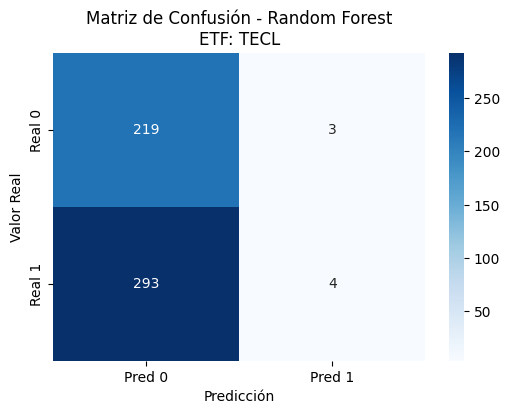

------------------------------

--- Procesando Clasificación para ETF: TQQQ ---
  Calculando características manuales para TQQQ...
  Características usadas: ['close_lag1', 'volume_lag1', 'SMA_10', 'ROC_14']
  Tamaño después de limpiar NaNs: 2958
  División para clasificación -> Train: 1892, Test: 474

  --- Evaluando: Logistic Regression ---
    Accuracy: 0.5549
    Precision: 0.5549
    Recall: 1.0000
    F1-Score: 0.7137
    ROC AUC: 0.4655


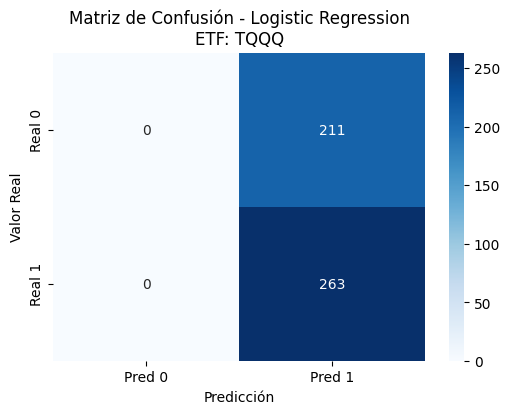


  --- Evaluando: Random Forest ---
    Accuracy: 0.5380
    Precision: 0.5724
    Recall: 0.6616
    F1-Score: 0.6138
    ROC AUC: 0.5067


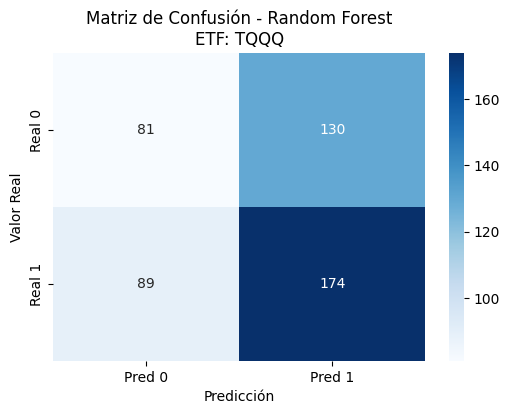

------------------------------

--- Procesando Clasificación para ETF: SOXL ---
  Calculando características manuales para SOXL...
  Características usadas: ['close_lag1', 'volume_lag1', 'SMA_10', 'ROC_14']
  Tamaño después de limpiar NaNs: 2939
  División para clasificación -> Train: 1880, Test: 471

  --- Evaluando: Logistic Regression ---
    Accuracy: 0.5520
    Precision: 0.5520
    Recall: 1.0000
    F1-Score: 0.7114
    ROC AUC: 0.4313


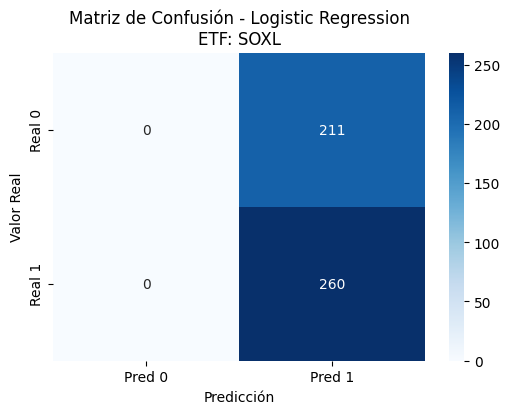


  --- Evaluando: Random Forest ---
    Accuracy: 0.5074
    Precision: 0.6429
    Recall: 0.2423
    F1-Score: 0.3520
    ROC AUC: 0.5247


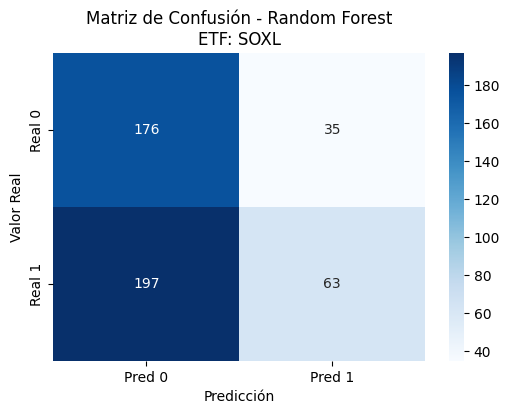

------------------------------

--- Procesando Clasificación para ETF: RETL ---
  Calculando características manuales para RETL...
  Características usadas: ['close_lag1', 'volume_lag1', 'SMA_10', 'ROC_14']
  Tamaño después de limpiar NaNs: 2853
  División para clasificación -> Train: 1825, Test: 457

  --- Evaluando: Logistic Regression ---
    Accuracy: 0.5449
    Precision: 0.5501
    Recall: 0.9402
    F1-Score: 0.6941
    ROC AUC: 0.4883


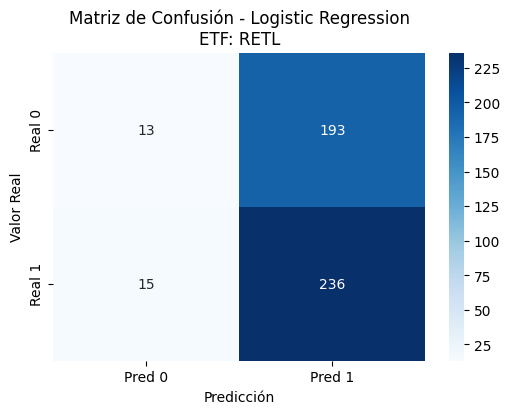


  --- Evaluando: Random Forest ---
    Accuracy: 0.5033
    Precision: 0.5550
    Recall: 0.4821
    F1-Score: 0.5160
    ROC AUC: 0.5241


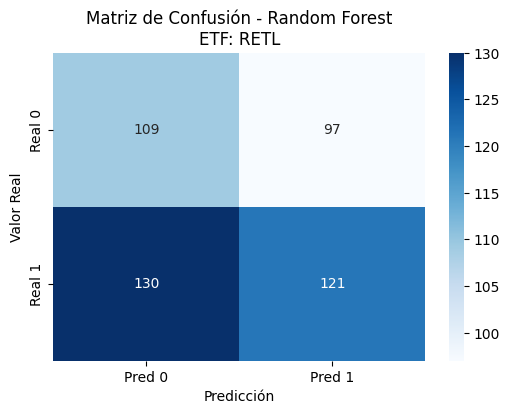

------------------------------

--- Procesando Clasificación para ETF: UPRO ---
  Calculando características manuales para UPRO...
  Características usadas: ['close_lag1', 'volume_lag1', 'SMA_10', 'ROC_14']
  Tamaño después de limpiar NaNs: 3117
  División para clasificación -> Train: 1994, Test: 499

  --- Evaluando: Logistic Regression ---
    Accuracy: 0.4469
    Precision: 1.0000
    Recall: 0.0072
    F1-Score: 0.0143
    ROC AUC: 0.5694


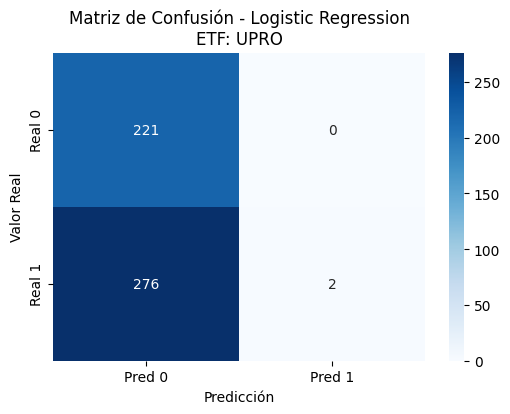


  --- Evaluando: Random Forest ---
    Accuracy: 0.4569
    Precision: 0.5814
    Recall: 0.0899
    F1-Score: 0.1558
    ROC AUC: 0.5112


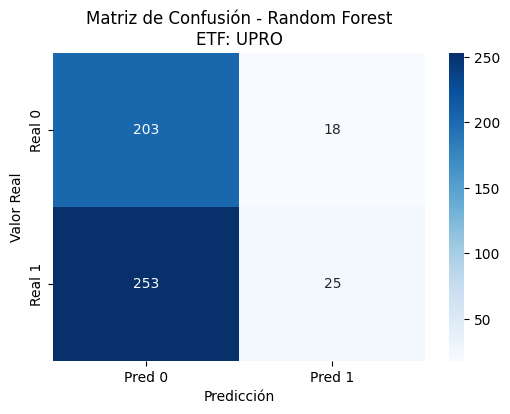

------------------------------

Análisis de Clasificación (Manual Features) Completado.


In [ ]:
import pandas as pd
import numpy as np
# --- Modelos y Herramientas ---
from sklearn.model_selection import train_test_split # Usaremos train_test_split para dividir la porción de interpolación
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns
# --- Otros ---
import warnings
from datetime import timedelta

# Ignorar algunas advertencias comunes
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


# --- 0. Carga y Preparación Inicial ---
# Asegúrate de que df_top20 esté cargado
# Ejemplo:
# df_top20 = pd.read_csv('tu_archivo_etfs.csv')

TOP_N_ETFS = 5 # Procesar solo los 5 primeros ETFs

required_cols = ['fund_symbol', 'price_date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'Clasificacion']
missing_cols = [col for col in required_cols if col not in df_top20.columns]
if missing_cols:
    raise ValueError(f"Faltan las siguientes columnas requeridas: {missing_cols}")

# --- 1. Preparar Datos y Seleccionar Top N ETFs por 'Clasificacion' ---
df_processed = df_top20.copy()
try:
    df_processed['price_date'] = pd.to_datetime(df_processed['price_date'])
except Exception as e:
    print(f"Error al convertir 'price_date': {e}")
    exit()

df_processed['Clasificacion'] = pd.to_numeric(df_processed['Clasificacion'], errors='coerce')
df_sorted_by_class = df_processed.sort_values(by=['Clasificacion', 'price_date'], ascending=[True, True], na_position='last')
ordered_symbols = df_sorted_by_class['fund_symbol'].unique()
top_N_etfs_list = [symbol for symbol in ordered_symbols if pd.notna(symbol)][:TOP_N_ETFS]

if len(top_N_etfs_list) < TOP_N_ETFS:
    print(f"Advertencia: Solo se encontraron {len(top_N_etfs_list)} ETFs únicos.")
else:
    print(f"Se seleccionaron los siguientes {len(top_N_etfs_list)} ETFs:")
print(top_N_etfs_list)
print("-" * 50)

# Ordenar el DF original para el bucle
df_top20 = df_top20.sort_values(by=['fund_symbol', 'price_date']).reset_index(drop=True)


# --- 2. Bucle para Procesar Cada ETF ---
classification_results = {}

for etf_symbol in top_N_etfs_list:
    print(f"\n--- Procesando Clasificación para ETF: {etf_symbol} ---")
    classification_results[etf_symbol] = {}

    # Filtrar datos
    df_etf = df_top20[df_top20['fund_symbol'] == etf_symbol].copy()
    df_etf = df_etf.sort_values(by='price_date').reset_index(drop=True)

    # Verificar datos suficientes ANTES de ingeniería de features
    min_data_points = 50 # Necesitamos margen para lags y ventanas de rolling
    if len(df_etf) < min_data_points:
        print(f"Datos insuficientes para {etf_symbol} (encontrados {len(df_etf)}, mínimo {min_data_points}). Saltando clasificación...")
        continue

    # --- 3. Ingeniería de Características para Clasificación (Manual) ---
    print(f"  Calculando características manuales para {etf_symbol}...")

    # 3.1 Crear Variable Objetivo (Target): Dirección del día siguiente
    df_etf['Price_Diff'] = df_etf['adj_close'].diff().shift(-1)
    df_etf['Target_Direction'] = np.where(df_etf['Price_Diff'] > 0, 1, 0)

    # 3.2 Crear Características (Features) Manualmente
    # Lags (datos del día anterior)
    df_etf['close_lag1'] = df_etf['adj_close'].shift(1)
    df_etf['volume_lag1'] = df_etf['volume'].shift(1)

    # SMA 10 (Simple Moving Average - Media Móvil Simple)
    sma_window = 10
    df_etf[f'SMA_{sma_window}'] = df_etf['adj_close'].rolling(window=sma_window).mean()

    # ROC 14 (Rate of Change - Tasa de Cambio)
    roc_window = 14
    # pct_change calcula (precio_actual - precio_hace_N) / precio_hace_N
    df_etf[f'ROC_{roc_window}'] = df_etf['adj_close'].pct_change(periods=roc_window) * 100 # Multiplicado por 100 para escala

    # Lista final de features a usar
    # Asegúrate de que los nombres coincidan con las columnas creadas
    features = ['close_lag1', 'volume_lag1', f'SMA_{sma_window}', f'ROC_{roc_window}']
    target = 'Target_Direction'
    print(f"  Características usadas: {features}")

    # 3.3 Limpiar NaNs generados por lags, rolling, pct_change y el shift del target
    df_etf_clean = df_etf.dropna(subset=features + [target]).copy()
    print(f"  Tamaño después de limpiar NaNs: {len(df_etf_clean)}")

    # Verificar datos suficientes DESPUÉS de limpiar NaNs
    if len(df_etf_clean) < 30: # Necesitamos suficientes para train/test split
        print(f"  Datos insuficientes para {etf_symbol} después de limpiar NaNs. Saltando clasificación...")
        continue

    # --- 4. Preparar Datos para Modelo ---
    X = df_etf_clean[features]
    y = df_etf_clean[target]
    dates_clean = df_etf_clean['price_date']

    # --- 5. División Interpolación (80%) / Extrapolación (20%) ---
    # (Similar al código anterior, se usa para dividir los datos limpios)
    n_total_clean = len(df_etf_clean)
    n_interp_clean = int(n_total_clean * 0.80)

    X_interp = X.iloc[:n_interp_clean]
    y_interp = y.iloc[:n_interp_clean]
    dates_interp = dates_clean.iloc[:n_interp_clean]


    # --- 6. Dividir Interpolación en Entrenamiento (80%) y Prueba (20%) ---
    if len(X_interp) < 10: # Asegurar mínimo para split
         print(f"  Conjunto de interpolación muy pequeño para dividir en train/test ({len(X_interp)}). Saltando.")
         continue

    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
        X_interp, y_interp, dates_interp, # Pasar fechas correspondientes
        test_size=0.20,
        shuffle=False # CRUCIAL para series temporales
    )

    print(f"  División para clasificación -> Train: {len(X_train)}, Test: {len(X_test)}")

    # Verificar si hay suficientes datos en Test para evaluar
    if len(X_test) == 0:
        print(f"  El conjunto de prueba está vacío para {etf_symbol}. Saltando evaluación.")
        continue
    # Verificar si ambas clases están presentes en y_test para ROC AUC
    test_classes_present = len(np.unique(y_test)) > 1


    # --- 7. Escalado de Características ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- 8. Entrenamiento y Evaluación de Modelos ---
    models_to_test = {
        "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000), # Balanced para clases desiguales
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
    }

    for model_name, model in models_to_test.items():
        print(f"\n  --- Evaluando: {model_name} ---")

        # Entrenar
        try:
            model.fit(X_train_scaled, y_train)
        except Exception as e:
            print(f"    Error entrenando {model_name}: {e}")
            continue

        # Predecir en el conjunto de prueba
        y_pred = model.predict(X_test_scaled)

        # Evaluar
        accuracy = accuracy_score(y_test, y_pred)
        # Usar zero_division=0 o 1 para evitar warnings/errores si no se predice una clase
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Calcular ROC AUC solo si hay ambas clases en y_test
        roc_auc = float('nan') # Valor por defecto
        if test_classes_present:
             try:
                 y_proba = model.predict_proba(X_test_scaled)[:, 1] # Probabilidad de la clase positiva (1)
                 roc_auc = roc_auc_score(y_test, y_proba)
             except Exception as e:
                  print(f"    Advertencia: No se pudo calcular ROC AUC para {model_name}: {e}")
        else:
            print(f"    Advertencia: Solo una clase presente en y_test. No se calcula ROC AUC.")


        print(f"    Accuracy: {accuracy:.4f}")
        print(f"    Precision: {precision:.4f}")
        print(f"    Recall: {recall:.4f}")
        print(f"    F1-Score: {f1:.4f}")
        print(f"    ROC AUC: {roc_auc:.4f}")


        # Guardar resultados (opcional)
        classification_results[etf_symbol][model_name] = {
            'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc
        }

        # Visualizar Matriz de Confusión
        try:
            cm = confusion_matrix(y_test, y_pred, labels=model.classes_) # Asegurar orden de etiquetas
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=[f'Pred {cls}' for cls in model.classes_],
                        yticklabels=[f'Real {cls}' for cls in model.classes_])
            plt.title(f'Matriz de Confusión - {model_name}\nETF: {etf_symbol}')
            plt.ylabel('Valor Real')
            plt.xlabel('Predicción')
            plt.show()
        except Exception as e:
            print(f"    Error al generar matriz de confusión para {model_name}: {e}")


    print("-" * 30)

print("\nAnálisis de Clasificación (Manual Features) Completado.")